# Training Analysis
In this notebook, we will analyze the training process of the models. We will plot the training and validation loss, as well as task-specific metrics for each model. We will also print the best metrics for each model to compare their performance.

### Import Libraries

In [1]:
# Import necessary libraries
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set the style for seaborn
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

### Load Metrics and Plotting Functions

In [2]:
# Define tasks and task-specific metrics
task_specific_metrics = {
    "segmentation": "dice",
    "malignancy": "auc",
    "noduletype": "balanced_accuracy"
}


def load_metrics(workspace, model_id):
    """Load metrics and best metrics for a given model ID."""
    metrics_path = workspace / "results" / model_id / "metrics.npy"
    best_metrics_path = workspace / "results" / model_id / "best_metrics.npy"
    metrics = np.load(metrics_path, allow_pickle=True).item()
    best_metrics = np.load(best_metrics_path, allow_pickle=True).item()
    return metrics, best_metrics


def plot_loss(metrics, tasks, ax):
    """Plot training and validation loss."""
    for task in tasks:
        # Plot training loss
        train_loss_values = [metrics["training"][i][task]["loss"] for i in range(len(metrics["training"]))]
        ax.plot(train_loss_values, label=f'Training {task.capitalize()}', color='blue', linestyle='--')

        # Plot validation loss
        val_loss_values = [metrics["validation"][i][task]["loss"] for i in range(len(metrics["validation"]))]
        ax.plot(val_loss_values, label=f'Validation {task.capitalize()}', color='orange')

    ax.legend(loc='upper right')
    ax.set_title("Training and Validation Loss")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_ylim([0, 2])
    sns.despine()
    ax.grid(True)


def plot_task_specific_metrics(metrics, tasks, task_specific_metrics, ax):
    """Plot task-specific metrics for training and validation."""
    for task in tasks:
        metric_name = task_specific_metrics[task].replace("_", " ").title()
        if task_specific_metrics[task] == "balanced_accuracy":
            metric_name = "Balanced Accuracy"

        # Plot training metrics
        train_metric_values = [metrics["training"][i][task][task_specific_metrics[task]] for i in
                               range(len(metrics["training"]))]
        ax.plot(train_metric_values, label=f'Training {task.capitalize()} {metric_name}', color='blue', linestyle='--')

        # Plot validation metrics
        val_metric_values = [metrics["validation"][i][task][task_specific_metrics[task]] for i in
                             range(len(metrics["validation"]))]
        ax.plot(val_metric_values, label=f'Validation {task.capitalize()} {metric_name}', color='orange')

        # Mark the best validation metric point
        best_epoch = np.argmax(val_metric_values)
        ax.plot(best_epoch, val_metric_values[best_epoch], 'o', color='red',
                label=f'Best {task.capitalize()} {metric_name}')

    ax.legend(loc='lower right')
    ax.set_title("Training and Validation Metrics")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric')
    ax.set_ylim([0, 1])
    sns.despine()
    ax.grid(True)


def plot_model_metrics(workspace, model_ids_tasks, titles):
    """Plot metrics for multiple models."""
    for i, (model_id, tasks) in enumerate(model_ids_tasks.items()):
        metrics, best_metrics = load_metrics(workspace, model_id)

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))

        # Plot training and validation loss
        plot_loss(metrics, tasks, axes[0])

        # Plot task-specific metrics for training and validation
        plot_task_specific_metrics(metrics, tasks, task_specific_metrics, axes[1])

        # Show the plot
        plt.suptitle(titles[i])
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        # Print best metrics for clarity
        print(f"\nBest Metrics for {titles[i]}:")
        for task in best_metrics:
            print(f"{task.capitalize()}:")
            for metric in best_metrics[task]:
                print(f"  {metric.capitalize()}: {best_metrics[task][metric]}")

### Plotting Functions for nnU-Net

In [3]:
def parse_nnunet_log(filepath):
    """Parse the nnU-Net training log file and return a DataFrame with the metrics."""
    with open(filepath, 'r') as file:
        lines = file.readlines()

    # Initialize lists to store the parsed data
    epochs = []
    train_losses = []
    val_losses = []
    pseudo_dices = []
    epoch_durations = []
    learning_rates = []

    best_mean_dice = None

    for line in lines:
        # Match the different lines in the log file using regular expressions
        epoch_match = re.match(r'^.*Epoch (\d+)', line)
        train_loss_match = re.match(r'^.*train_loss ([\d\.-]+)', line)
        val_loss_match = re.match(r'^.*val_loss ([\d\.-]+)', line)
        pseudo_dice_match = re.match(r'^.*Pseudo dice \[([\d\.-]+)\]', line)
        epoch_duration_match = re.match(r'^.*Epoch time: ([\d\.-]+) s', line)
        learning_rate_match = re.match(r'^.*Current learning rate: ([\d\.-]+)', line)
        best_mean_dice_match = re.match(r'^.*Mean Validation Dice: *([\d\.-]+)', line)

        if epoch_match:
            epochs.append(int(epoch_match.group(1)))
        if train_loss_match:
            train_losses.append(float(train_loss_match.group(1)))
        if val_loss_match:
            val_losses.append(float(val_loss_match.group(1)))
        if pseudo_dice_match:
            pseudo_dices.append(float(pseudo_dice_match.group(1)))
        if epoch_duration_match:
            epoch_durations.append(float(epoch_duration_match.group(1)))
        if learning_rate_match:
            learning_rates.append(float(learning_rate_match.group(1)))
        if best_mean_dice_match:
            best_mean_dice = float(best_mean_dice_match.group(1))

    # Create a DataFrame to hold the metrics
    metrics_df = pd.DataFrame({
        'epoch': epochs,
        'train_loss': train_losses,
        'val_loss': val_losses,
        'pseudo_dice': pseudo_dices,
        'epoch_duration': epoch_durations,
        'learning_rate': learning_rates
    })

    return metrics_df, best_mean_dice


def plot_nnunet_metrics(metrics_df, best_mean_dice):
    """Plot the training and validation loss, and pseudo dice score for nnU-Net."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot training and validation loss
    sns.lineplot(x='epoch', y='train_loss', data=metrics_df, ax=axes[0], label='Train Loss', color='blue')
    sns.lineplot(x='epoch', y='val_loss', data=metrics_df, ax=axes[0], label='Val Loss', color='orange')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend(loc='upper right')
    axes[0].grid(True)

    # Plot pseudo dice score
    sns.lineplot(x='epoch', y='pseudo_dice', data=metrics_df, ax=axes[1], label='Validation Pseudo Dice',
                 color='orange', linestyle='--')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Pseudo Dice')
    axes[1].set_title('Validation Pseudo Dice Score')
    axes[1].legend(loc='lower right')
    axes[1].grid(True)

    plt.suptitle(
        f"Best Mean Validation Dice: {best_mean_dice:.4f}" if best_mean_dice is not None else "Best Mean Validation Dice: N/A")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### Model Analysis
#### U-Net, 3D-CNNs, and Vision Transformer

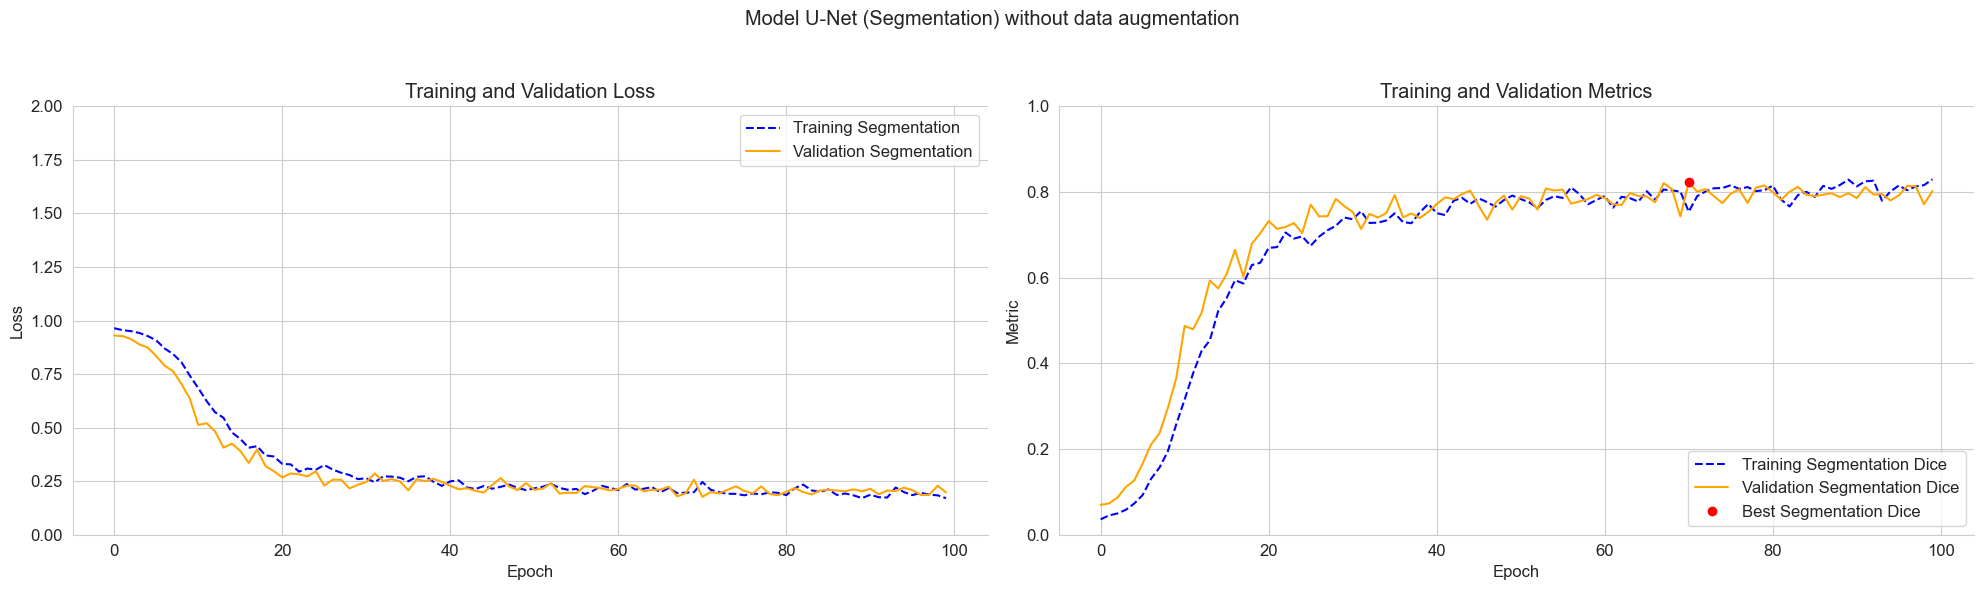


Best Metrics for Model U-Net (Segmentation) without data augmentation:
Segmentation:
  Loss: 0.17673895699637276
  Dice: 0.8232610430036272
Cumulative:
  Loss: 0.17673895699637276


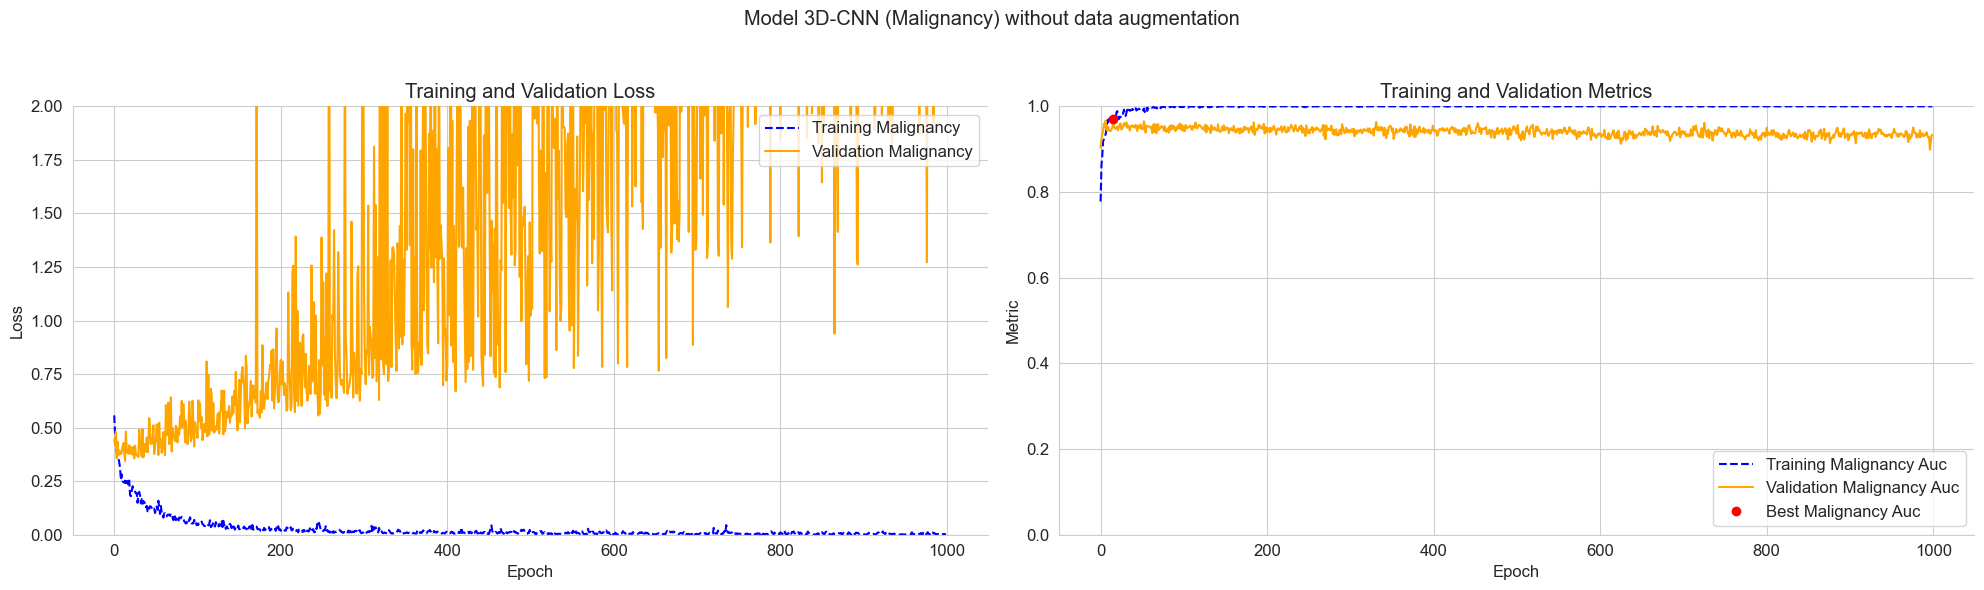


Best Metrics for Model 3D-CNN (Malignancy) without data augmentation:
Malignancy:
  Loss: 0.38794643580913546
  Auc: 0.9715277777777778
Cumulative:
  Loss: 0.38794643580913546


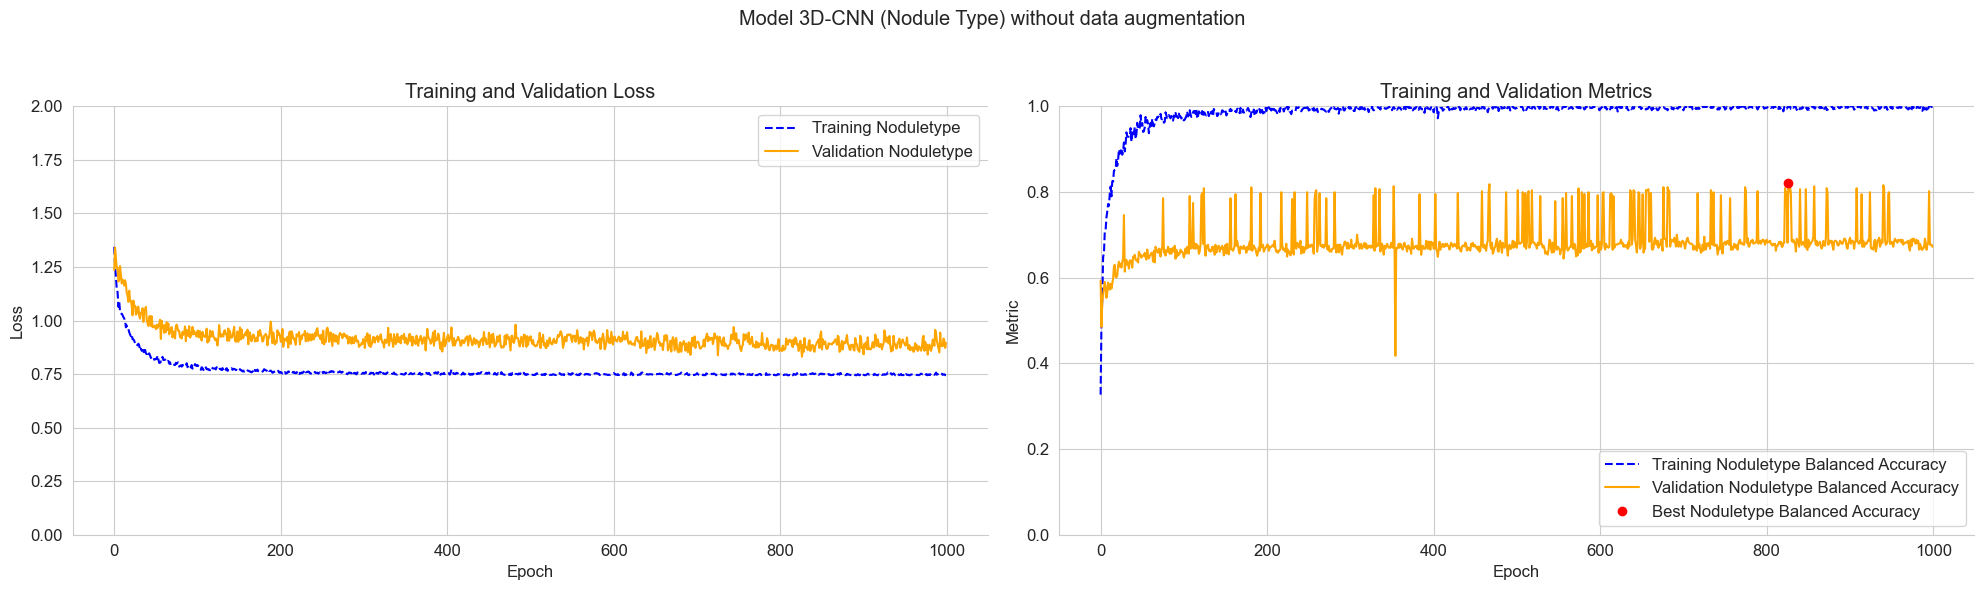


Best Metrics for Model 3D-CNN (Nodule Type) without data augmentation:
Noduletype:
  Loss: 0.8312093496322632
  Balanced_accuracy: 0.8205941255006676
Cumulative:
  Loss: 0.8312093496322632


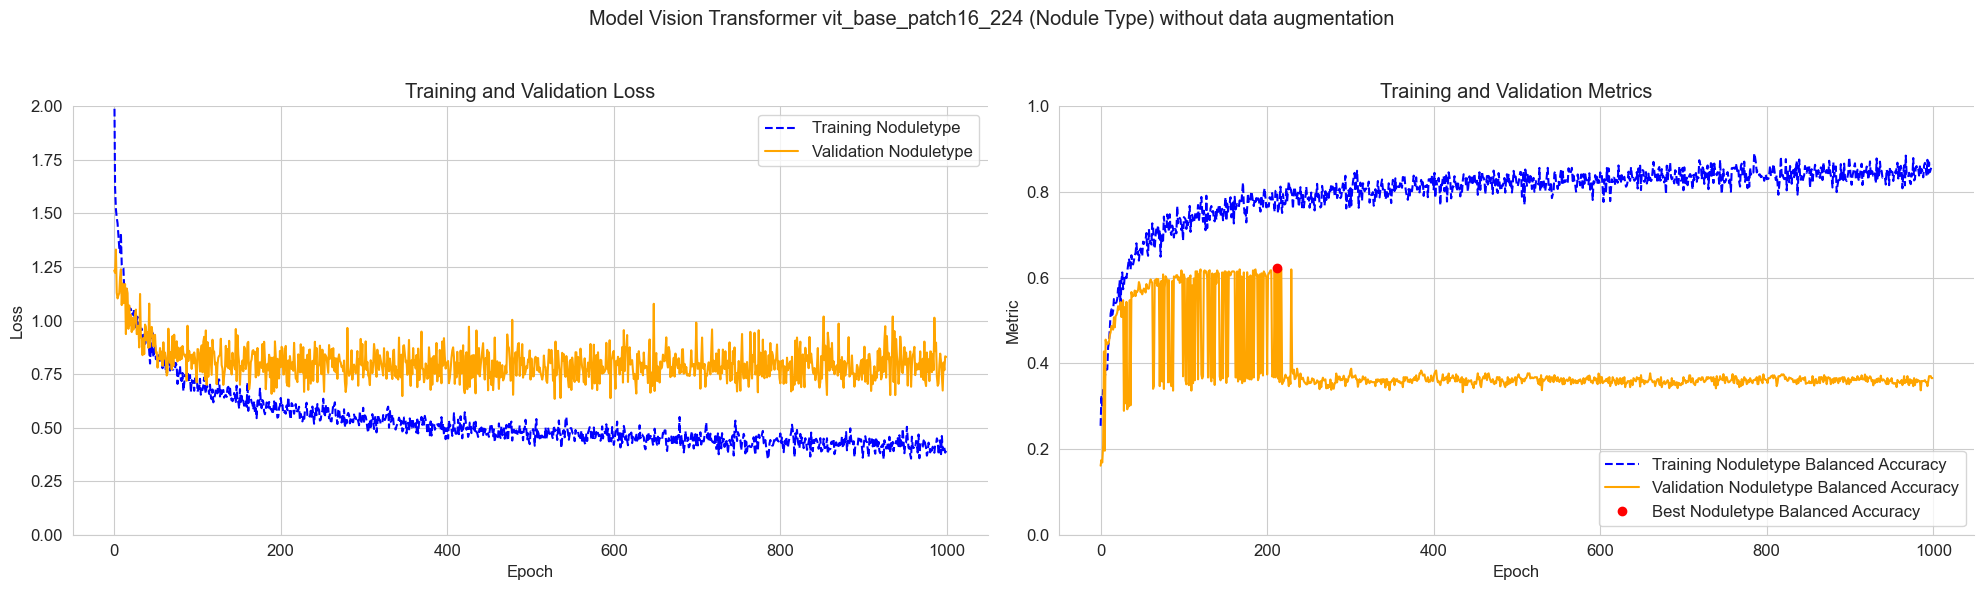


Best Metrics for Model Vision Transformer vit_base_patch16_224 (Nodule Type) without data augmentation:
Noduletype:
  Loss: 0.787656557559967
  Balanced_accuracy: 0.6216622162883845
Cumulative:
  Loss: 0.787656557559967


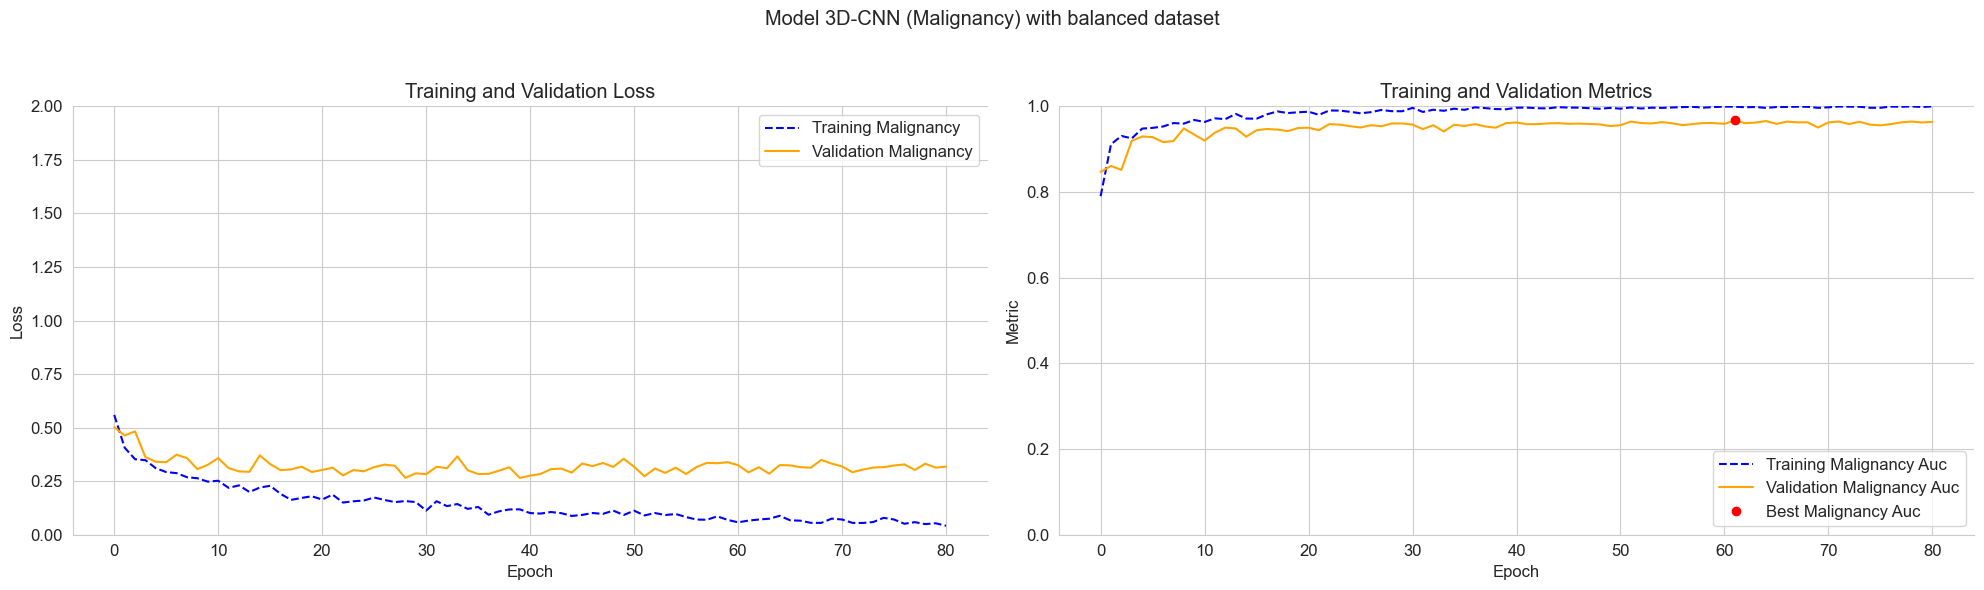


Best Metrics for Model 3D-CNN (Malignancy) with balanced dataset:
Malignancy:
  Loss: 0.2911596723965236
  Auc: 0.9672046703296703
Cumulative:
  Loss: 0.2911596723965236


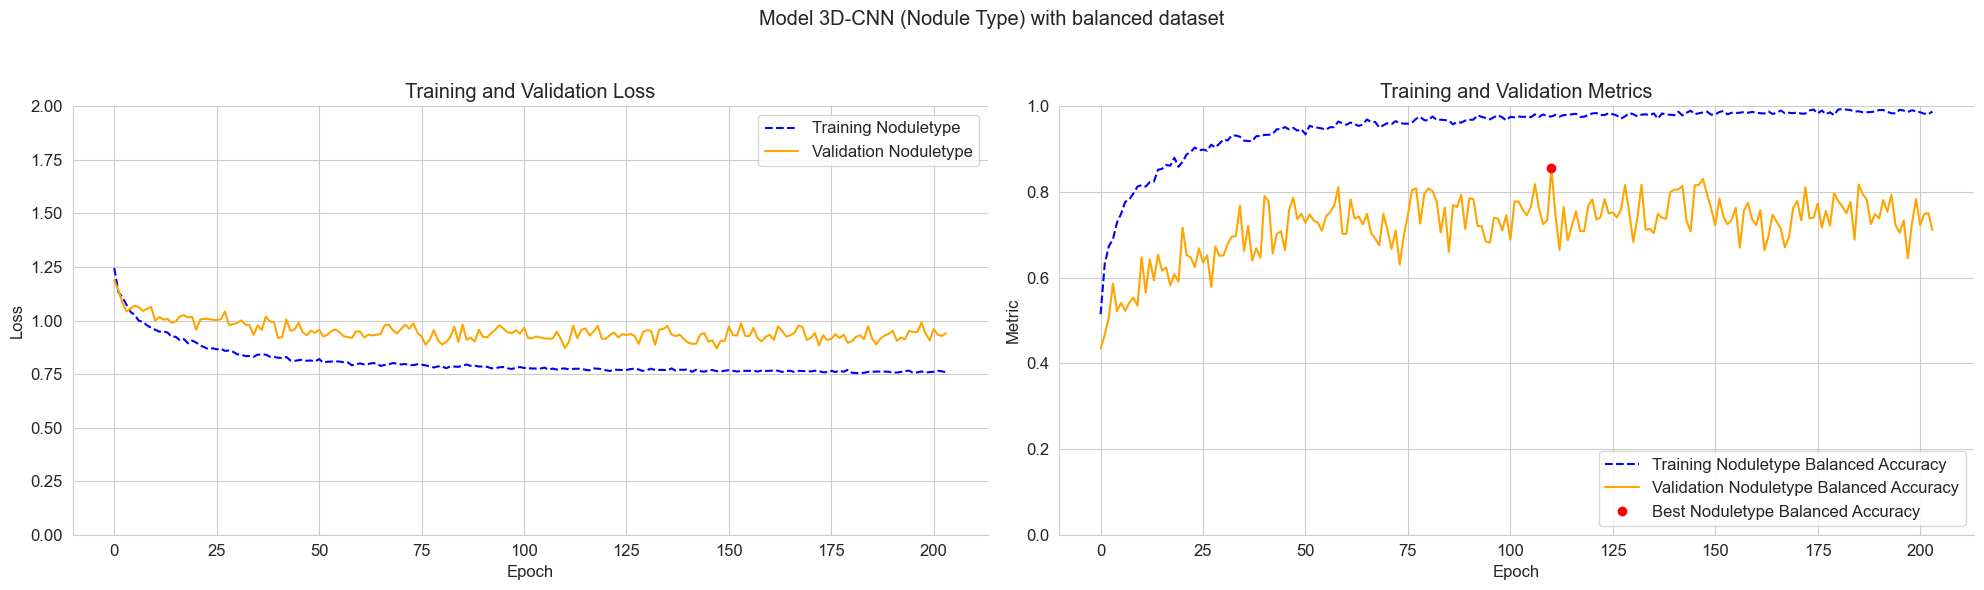


Best Metrics for Model 3D-CNN (Nodule Type) with balanced dataset:
Noduletype:
  Loss: 0.871098518371582
  Balanced_accuracy: 0.8549030899529992
Cumulative:
  Loss: 0.871098518371582


In [5]:
# Define the workspace path
workspace = Path("../")

# Define the model IDs and tasks to analyze
model_ids_tasks = {
    "20240526_0_segmentation_ORIGINAL/fold0/": ["segmentation"],
    "20240526_0_malignancy_ORIGINAL/fold0/": ["malignancy"],
    "20240526_0_noduletype_ORIGINAL/fold0/": ["noduletype"],
    "ViT_noduletype_ORIGINAL/20240522_0_noduletype/fold0/": ["noduletype"],
    "20240527_0_malignancy_BALANCED_DATASET_ME/fold0/": ["malignancy"],
    "20240525_0_noduletype_BALANCED_DATASET/fold0/": ["noduletype"],
}

# Define the titles for the plots
titles = [
    "Model U-Net (Segmentation) without data augmentation",
    "Model 3D-CNN (Malignancy) without data augmentation",
    "Model 3D-CNN (Nodule Type) without data augmentation",
    "Model Vision Transformer vit_base_patch16_224 (Nodule Type) without data augmentation",
    "Model 3D-CNN (Malignancy) with balanced dataset",
    "Model 3D-CNN (Nodule Type) with balanced dataset"
]

plot_model_metrics(workspace, model_ids_tasks, titles)

#### nnU-Net

In [7]:
# For nnU-Net model:
# Define the path to the training log file
log_filepath = '../results/nnUNetTrainer_model/training_log_2024_5_28_07_40_25.txt'

# Parse the nnU-Net training log with the updated regex
nnunet_metrics, best_mean_dice = parse_nnunet_log(log_filepath)

# Display the first few rows and describe the DataFrame to inspect the parsed data
nnunet_metrics.head(), nnunet_metrics.describe()

(   epoch  train_loss  val_loss  pseudo_dice  epoch_duration  learning_rate
 0      0      0.0465   -0.0212       0.0000          200.13        0.01000
 1      1     -0.0332   -0.0495       0.0106           70.51        0.00999
 2      2     -0.0973   -0.1679       0.0384           71.46        0.00998
 3      3     -0.2411   -0.3900       0.1326           73.13        0.00997
 4      4     -0.4234   -0.5222       0.5932           69.85        0.00996,
              epoch   train_loss     val_loss  pseudo_dice  epoch_duration  \
 count  1000.000000  1000.000000  1000.000000  1000.000000     1000.000000   
 mean    499.500000    -0.788077    -0.818611     0.886625       74.813710   
 std     288.819436     0.067303     0.067886     0.068620       12.892665   
 min       0.000000    -0.871300    -0.908500     0.000000       66.620000   
 25%     249.750000    -0.824800    -0.858400     0.873200       70.700000   
 50%     499.500000    -0.795500    -0.827150     0.897800       72.210000 

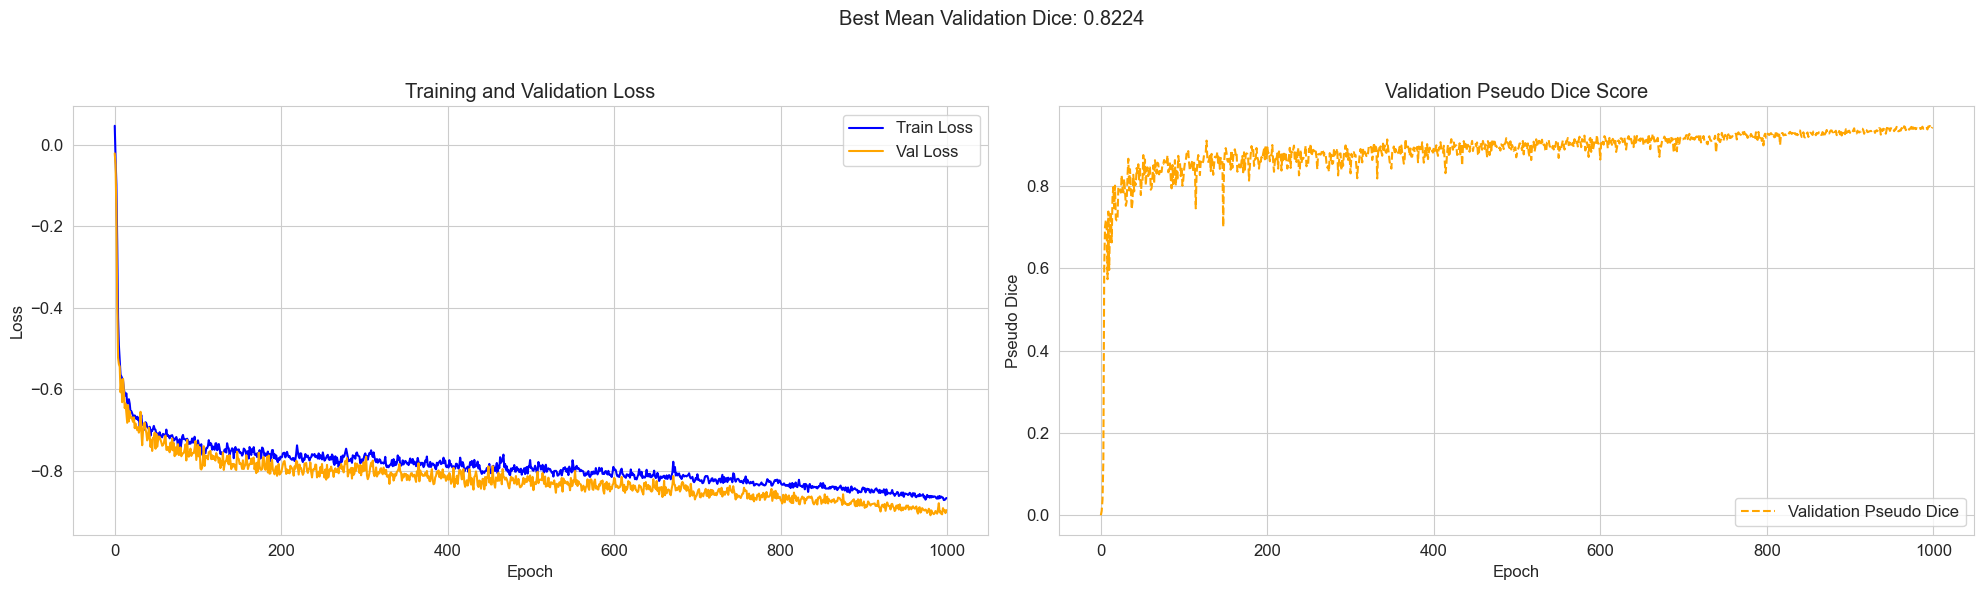

In [8]:
plot_nnunet_metrics(nnunet_metrics, best_mean_dice)